In [2]:
from IPython.display import clear_output
!pip install -U datasets
clear_output()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 19.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch

dataset = load_dataset("merve/poetry", split="train")
labels = list(set(dataset['type']))
label2id = {label: i for i, label in enumerate(labels)}

Repo card metadata block was not found. Setting CardData to empty.


In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def preprocess(example):
    return tokenizer(
        example["content"],
        padding="max_length",
        truncation=True,
        max_length=128
    ) | {"labels": label2id[example["type"]]}

dataset = dataset.map(preprocess, batched=False)

In [5]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=len(labels)
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    num_train_epochs=2,
    eval_strategy="no",
    logging_steps=10,
    learning_rate=2e-5,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
)

trainer.train()

Step,Training Loss
10,0.982100
20,0.872600
30,0.860300
40,0.859200
50,0.786100
60,0.922000
70,0.820400
80,0.820100
90,0.832400
100,0.756600


TrainOutput(global_step=144, training_loss=0.8185296671258079, metrics={'train_runtime': 17.8114, 'train_samples_per_second': 64.341, 'train_steps_per_second': 8.085, 'total_flos': 37952586533376.0, 'train_loss': 0.8185296671258079, 'epoch': 2.0})

In [60]:
text = dataset[0]['content']
inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=128).to('cuda:0')

outputs = model(**inputs, output_attentions=True)
attentions = outputs.attentions

Проследим, как меняется карта внимания на разных слоях модели

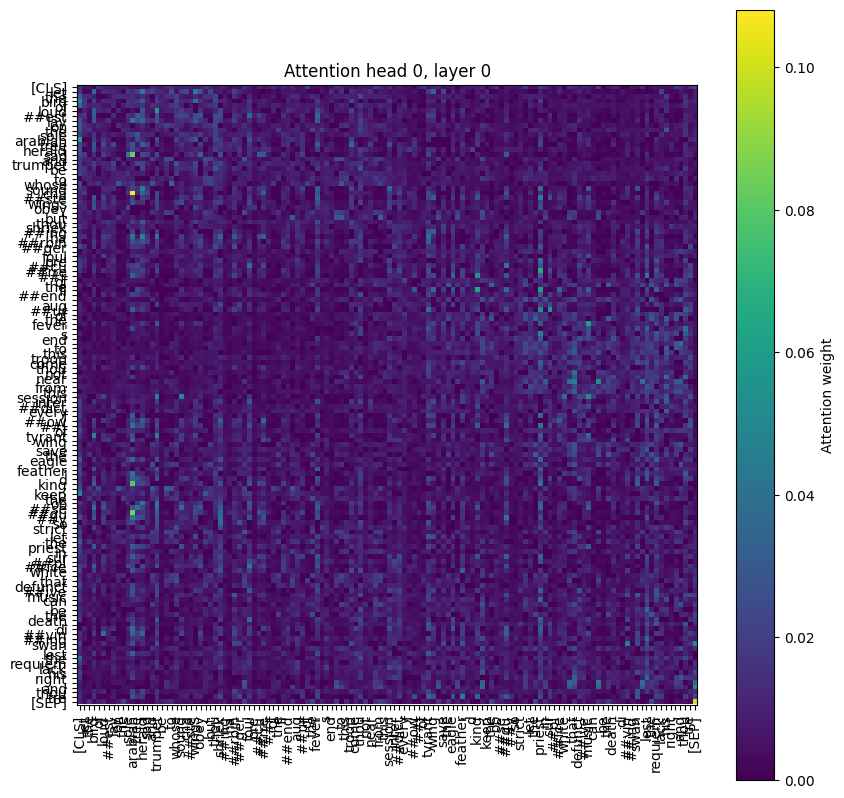

In [64]:
import matplotlib.pyplot as plt
import numpy as np

att = attentions[0][0, 0].detach().cpu().numpy()  # [seq_len, seq_len]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(10,10))
plt.imshow(att, cmap='viridis')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar(label='Attention weight')
plt.title('Attention head 0, layer 0')
plt.show()

Важные с точки зрения внимания токены:

In [68]:
print(np.array(tokens)[((att > 0.05).sum(axis=0) >= 1)])

['[CLS]' 'bird' 'arabian' 'trumpet' 'sound' 'king' 'priest' 'sur' 'music'
 ',' '[SEP]']


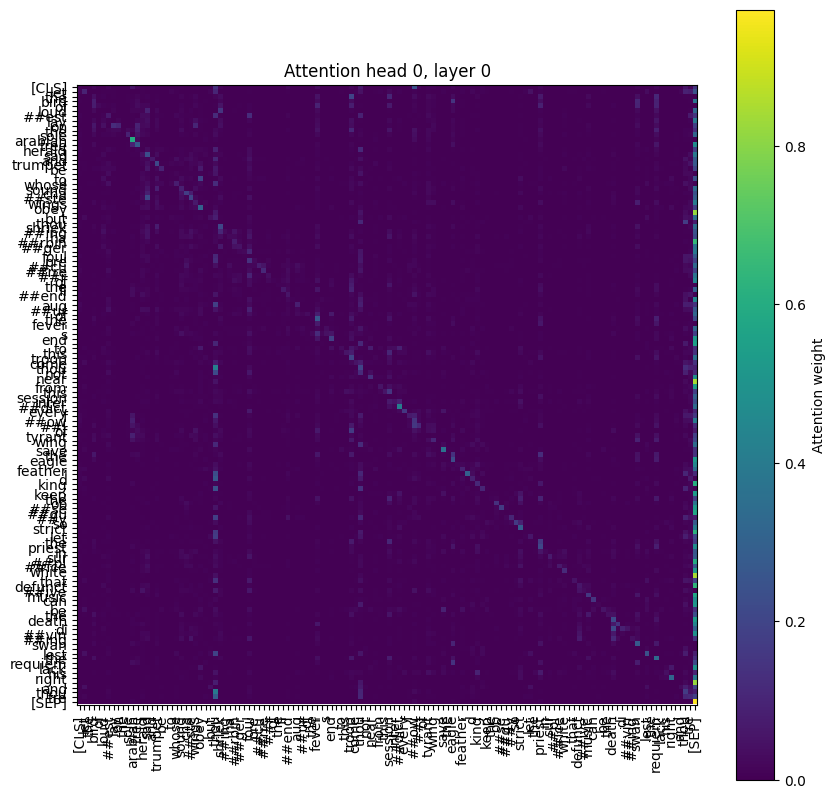

In [62]:
import matplotlib.pyplot as plt
import numpy as np

att = attentions[4][0, 0].detach().cpu().numpy()  # [seq_len, seq_len]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(10,10))
plt.imshow(att, cmap='viridis')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar(label='Attention weight')
plt.title('Attention head 0, layer 0')
plt.show()

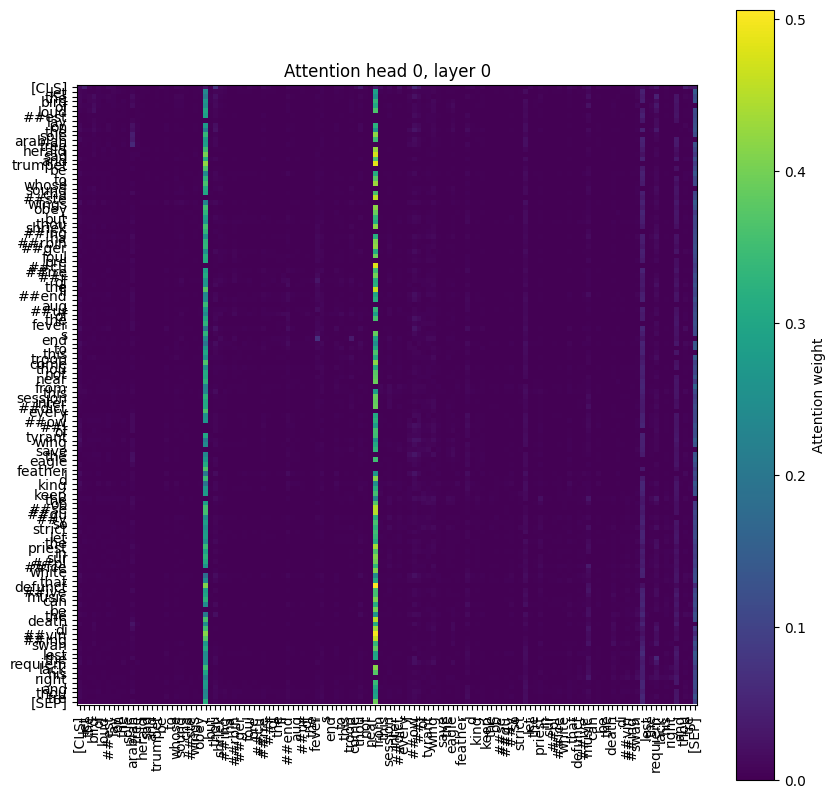

In [63]:
import matplotlib.pyplot as plt
import numpy as np

att = attentions[5][0, 0].detach().cpu().numpy()  # [seq_len, seq_len]
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(10,10))
plt.imshow(att, cmap='viridis')
plt.xticks(range(len(tokens)), tokens, rotation=90)
plt.yticks(range(len(tokens)), tokens)
plt.colorbar(label='Attention weight')
plt.title('Attention head 0, layer 0')
plt.show()

**Выводы**

По карте внимания видно, что многие косвенно связанные с поэзией и ее жанром слова имеют значимый вес.

Также видно, что ближе к последнему слою на карте внимания появляется все больше ярковыраженных полос, что свидетельствует о том, что модель распределила выделение разных смыслов токенов на разных слоях внимания.